In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal=sns.color_palette()

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
df=pd.read_csv('train_IxoE5JN.csv',index_col='datetime',parse_dates=True)
df.drop('row_id',axis=1,inplace=True)

In [ ]:
df

,energy
datetime,
2008-03-01 00:00:00,1259.985563
2008-03-01 01:00:00,1095.541500
2008-03-01 02:00:00,1056.247500
2008-03-01 03:00:00,1034.742000
2008-03-01 04:00:00,1026.334500
...,...
2018-12-31 19:00:00,2528.446800
2018-12-31 20:00:00,2461.883600
2018-12-31 21:00:00,2365.994400


In [ ]:
#Handle missing values
df.interpolate(method="polynomial", order=2,inplace=True)

#df.ffill(inplace=True)

In [ ]:
df.isna().sum()

energy    0
dtype: int64

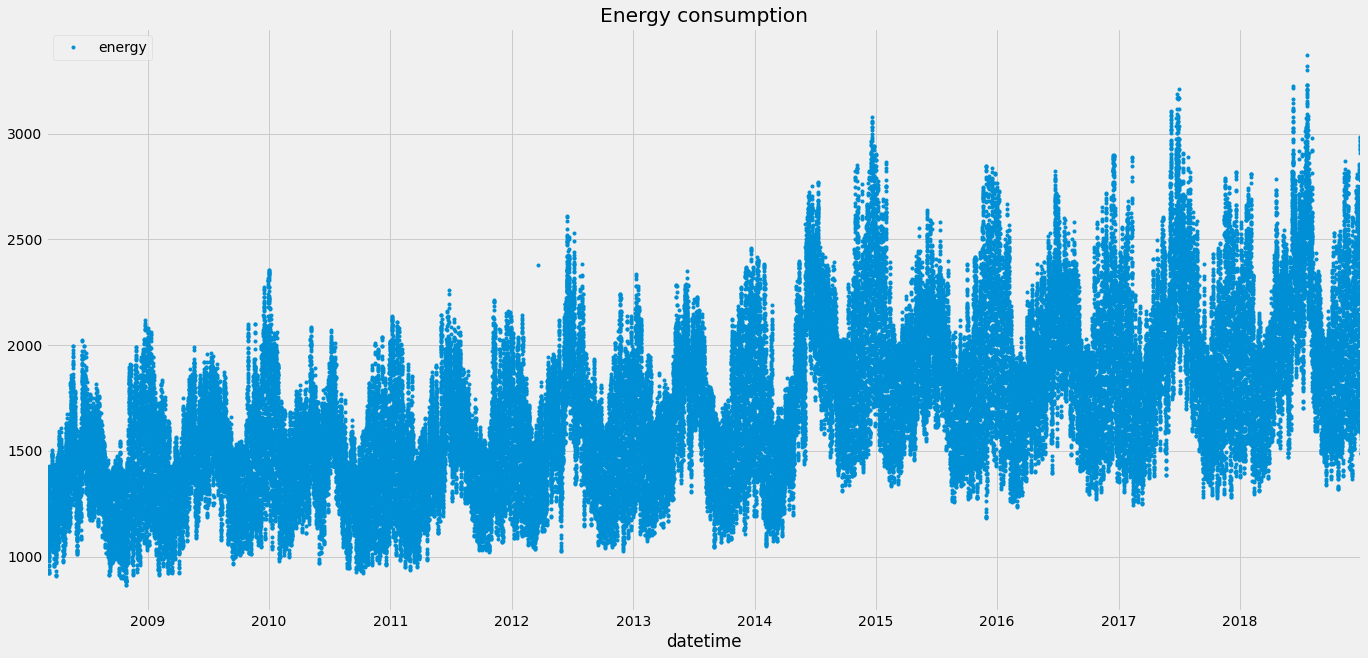

In [ ]:
df.plot(style='.',figsize=(21,10),color=color_pal[0],title='Energy consumption')

#Outlier analysis and removal

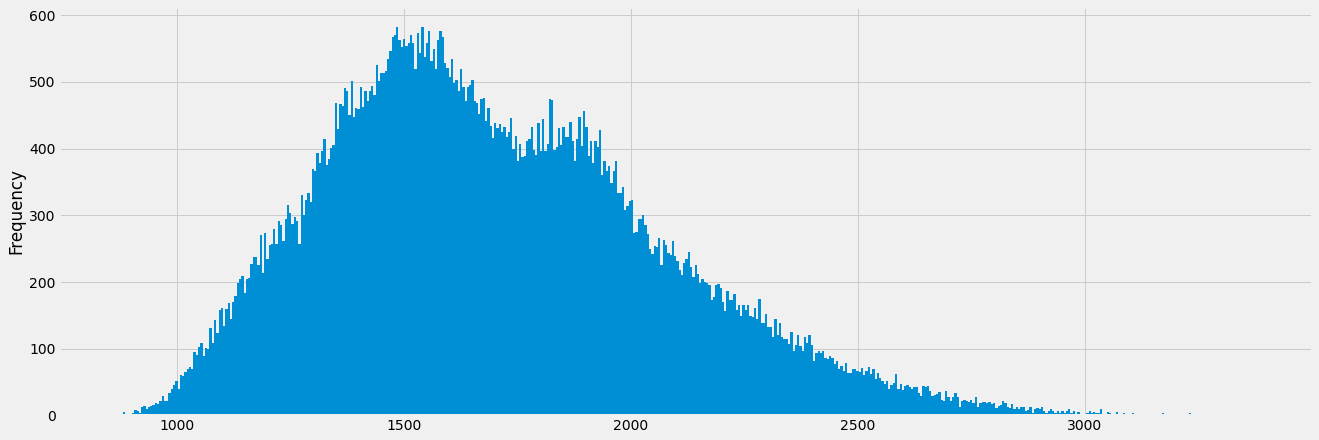

In [ ]:
df['energy'].plot(kind='hist',bins=500,figsize=(20,7))

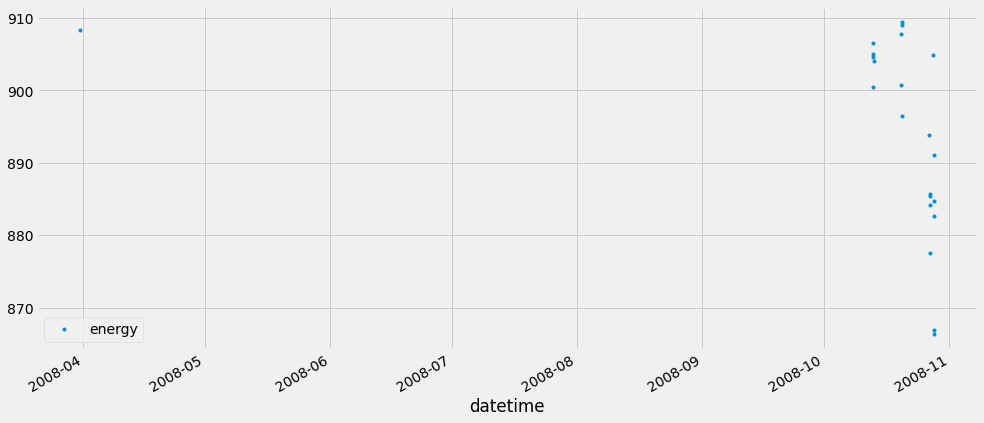

In [ ]:
df.query('energy < 910').plot(figsize=(15,7),style='.')

In [ ]:
#removing outliers
df=df.query('energy > 910').copy()

#TimeSeries Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tss=TimeSeriesSplit(n_splits=3,test_size=24*365*3,gap=24)
df=df.sort_index()

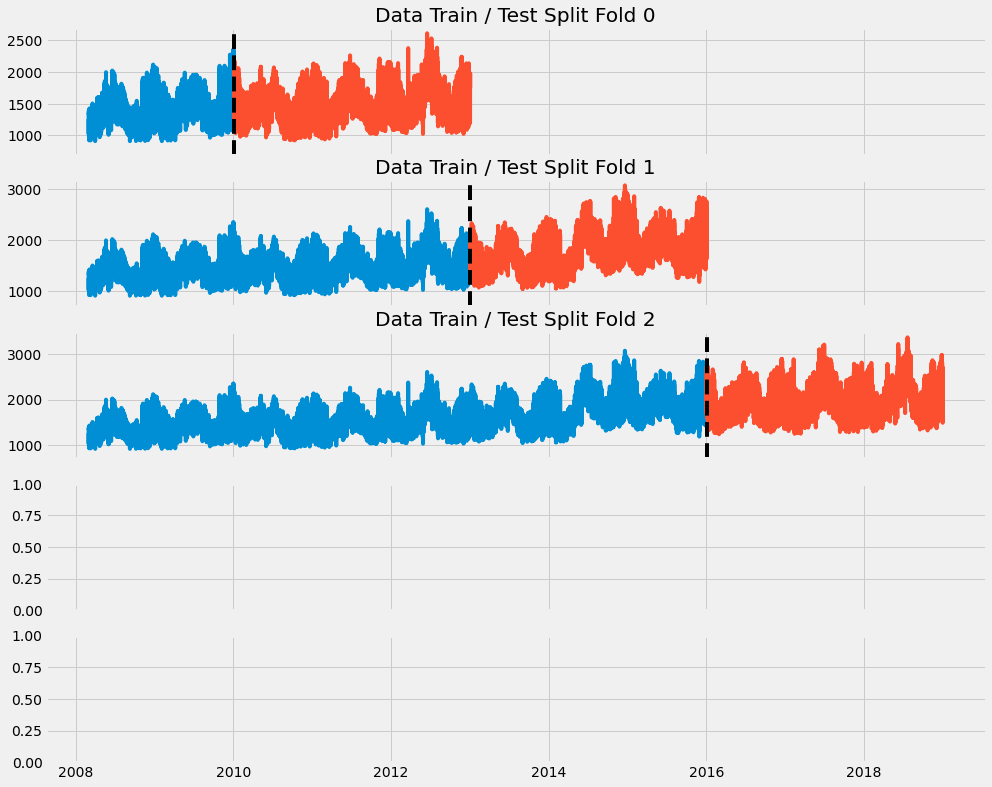

In [ ]:
fig,ax=plt.subplots(5,1,figsize=(15,15),sharex=True)

fold=0
for train_idx,val_idx in tss.split(df):

    train=df.iloc[train_idx]
    test=df.iloc[val_idx]

    train['energy'].plot(ax=ax[fold],label='Training Set', title=f'Data Train / Test Split Fold {fold}')
    test['energy'].plot(ax=ax[fold],label='Test Set')
    ax[fold].axvline(test.index.min(),ls='--',color='black')
    #ax[fold].set_ylim(auto=True)
    ax[fold].set_ybound(lower=700)

    fold+=1

#Forecasting Horizon 
Forecast horizon is the length of time into the future for which forecasts are to be prepared.

In [ ]:
def create_features(df):
    df=df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    df['low_hr_consumption']=( df['hour'] == 3 ) | ( df['hour'] == 4 ) |( df['hour'] == 5 )
    df['low_hr_consumption'].replace({True:1,False:0},inplace=True)
    return df
    
df=create_features(df)

#Lag Features
What was the target in the past ?

In [ ]:
def add_lags(df):
    target_map=df['energy'].to_dict()
    
    df['lag_1year']=(df.index - pd.Timedelta(f'{366*3} Days')).map(target_map)
    df['lag_2year']=(df.index - pd.Timedelta(f'{366*4} Days')).map(target_map)
    df['lag_3year']=(df.index - pd.Timedelta(f'{366*5} Days')).map(target_map)
    df['lag_4year']=(df.index - pd.Timedelta(f'{366*6} Days')).map(target_map)
    df['lag_5year']=(df.index - pd.Timedelta(f'{366*7} Days')).map(target_map)
    return df

df=add_lags(df)

#Visualize features

Text(0.5, 1.0, 'Consumption by hour')

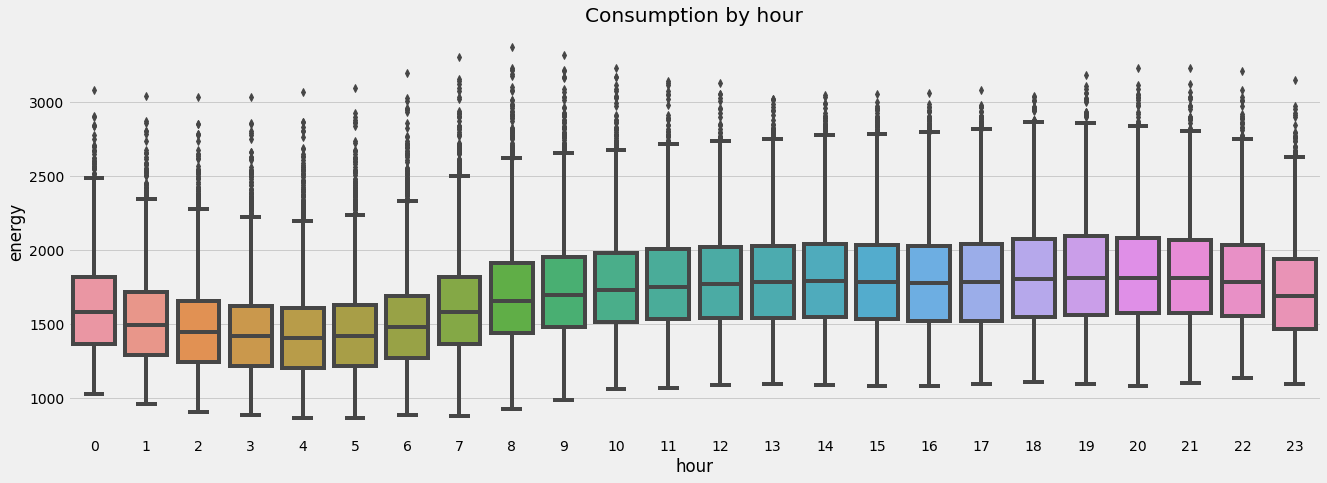

In [ ]:
fig,ax=plt.subplots(figsize=(20,7))
sns.boxplot(data=df,x='hour',y='energy')
ax.set_title('Consumption by hour')

Text(0.5, 1.0, 'Consumption by month')

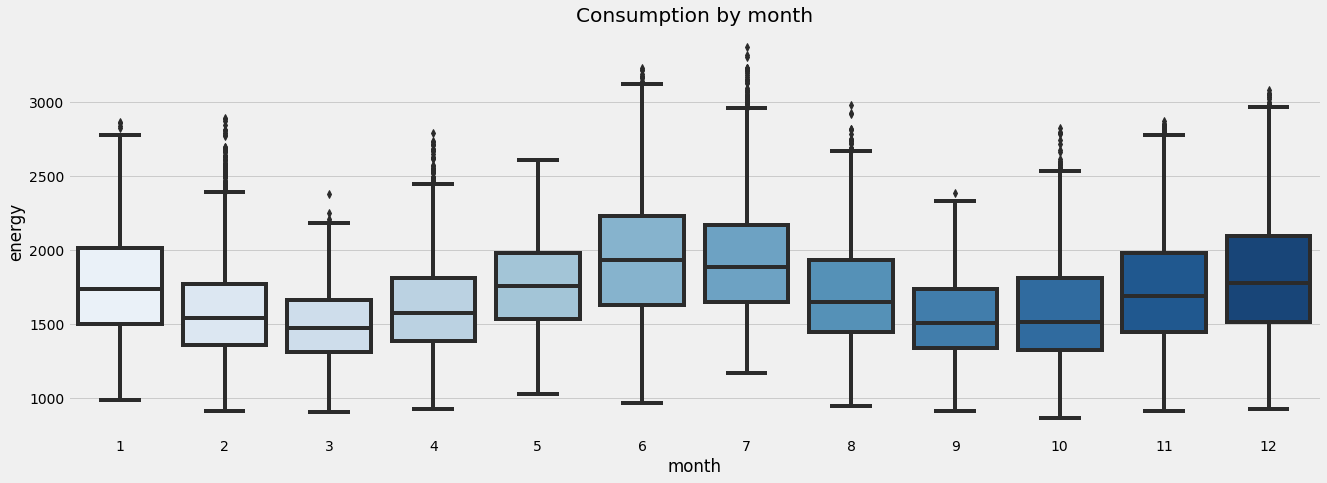

In [ ]:
fig,ax=plt.subplots(figsize=(20,7))
sns.boxplot(data=df,x='month',y='energy',palette='Blues')
ax.set_title('Consumption by month')

In [ ]:
df

,energy,hour,dayofweek,quarter,month,year,dayofyear,low_hr_consumption,lag_1year,lag_2year,lag_3year,lag_4year,lag_5year
datetime,,,,,,,,,,,,,
2008-03-01 00:00:00,1259.985563,0,5,1,3,2008,61,0,NaN,NaN,NaN,NaN,NaN
2008-03-01 01:00:00,1095.541500,1,5,1,3,2008,61,0,NaN,NaN,NaN,NaN,NaN
2008-03-01 02:00:00,1056.247500,2,5,1,3,2008,61,0,NaN,NaN,NaN,NaN,NaN
2008-03-01 03:00:00,1034.742000,3,5,1,3,2008,61,1,NaN,NaN,NaN,NaN,NaN
2008-03-01 04:00:00,1026.334500,4,5,1,3,2008,61,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,2528.446800,19,0,4,12,2018,365,0,2610.0698,2569.6048,2152.8080,2061.3614,1794.5925
2018-12-31 20:00:00,2461.883600,20,0,4,12,2018,365,0,2525.0186,2483.2168,2063.0904,1994.5590,1725.2175
2018-12-31 21:00:00,2365.994400,21,0,4,12,2018,365,0,2439.9674,2412.2284,1973.9944,1966.1257,1675.0825


#Training using cross validation

In [ ]:
tss=TimeSeriesSplit(n_splits=3,test_size=24*365*3,gap=24)
df=df.sort_index()

fold=0
preds=[]
scores=[]
target='energy'
#features=['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag_1year', 'lag_2year', 'lag_3year']
features=[col for col in df.columns if col != target]


for train_idx,val_idx in tss.split(df):
    X_train=df.iloc[train_idx][features]
    y_train=df.iloc[train_idx][target]

    X_test=df.iloc[val_idx][features]
    y_test=df.iloc[val_idx][target]

    params={'learning_rate': 0.12641011119320072,
    'reg_lambda': 54.13088458753243,
    'reg_alpha': 33.869285196363606,
    'subsample': 0.418068713418121,
    'colsample_bytree': 0.215986138630027,
    'max_depth': 5}


    learning_rate = 0.12641011119320072
    reg_lambda = 54.13088458753243
    reg_alpha = 33.869285196363606
    subsample = 0.418068713418121
    colsample_bytree = 0.215986138630027
    max_depth = 5
    
    #reg = xgb.XGBRegressor(
    #        random_state=42,
    #        #tree_method="gpu_hist",
    #        #gpu_id=1,
    #        #predictor="gpu_predictor",
    #        n_estimators=7000,
    #        learning_rate=learning_rate,
    #        reg_lambda=reg_lambda,
    #        reg_alpha=reg_alpha,
    #        subsample=subsample,
    #        colsample_bytree=colsample_bytree,
    #        max_depth=max_depth,
    #        
    #        n_jobs=-1
    #    )
            
    reg=xgb.XGBRegressor(base_score=0.5,booster='gbtree',n_estimators=1500,
                         objective='reg:squarederror',max_depth=3,learning_rate=0.04 ,n_jobs=-1)

    reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100,early_stopping_rounds=200)
    #reg.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=100)
    y_pred=reg.predict(X_test)
    preds.append(y_pred)
    score=np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)


[0]	validation_0-rmse:1386	validation_1-rmse:1466.32
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:119.541	validation_1-rmse:190.101
[200]	validation_0-rmse:100.847	validation_1-rmse:175.835
[300]	validation_0-rmse:92.3421	validation_1-rmse:185.107
Stopping. Best iteration:
[158]	validation_0-rmse:105.835	validation_1-rmse:171.004

[0]	validation_0-rmse:1434.33	validation_1-rmse:1773.24
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:140.359	validation_1-rmse:340.402
[200]	validation_0-rmse:122.719	validation_1-rmse:313.45
[300]	validation_0-rmse:115.053	validation_1-rmse:311.139
[400]	validation_0-rmse:110.265	validation_1-rmse:310.75
[500]	validation_0-rmse:105.196	validation_1-rmse:309.297
[600]	validation_0-rmse:

In [ ]:
print('Scores = ',scores)
print('Mean Score = ',np.mean(scores))

Scores =  [171.003554217693, 308.2523094378347, 209.96606975778417]
Mean Score =  229.740644471104


### base mean = 239.22780527730984
### interpolate = 236.7134386815618

#Predicting future

In [ ]:
df

,energy,hour,dayofweek,quarter,month,year,dayofyear,low_hr_consumption,lag_1year,lag_2year,lag_3year,lag_4year,lag_5year
datetime,,,,,,,,,,,,,
2008-03-01 00:00:00,1259.985563,0,5,1,3,2008,61,0,NaN,NaN,NaN,NaN,NaN
2008-03-01 01:00:00,1095.541500,1,5,1,3,2008,61,0,NaN,NaN,NaN,NaN,NaN
2008-03-01 02:00:00,1056.247500,2,5,1,3,2008,61,0,NaN,NaN,NaN,NaN,NaN
2008-03-01 03:00:00,1034.742000,3,5,1,3,2008,61,1,NaN,NaN,NaN,NaN,NaN
2008-03-01 04:00:00,1026.334500,4,5,1,3,2008,61,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,2528.446800,19,0,4,12,2018,365,0,2610.0698,2569.6048,2152.8080,2061.3614,1794.5925
2018-12-31 20:00:00,2461.883600,20,0,4,12,2018,365,0,2525.0186,2483.2168,2063.0904,1994.5590,1725.2175
2018-12-31 21:00:00,2365.994400,21,0,4,12,2018,365,0,2439.9674,2412.2284,1973.9944,1966.1257,1675.0825


In [ ]:
#Retrain on all data

#1st submission
#reg=xgb.XGBRegressor(base_score=0.5,booster='gbtree',n_estimators=1000,
#                         objective='reg:squarederror',max_depth=1,learning_rate=0.1,n_jobs=-1)
#reg.fit(df[features],df[target],eval_set=[(df[features],df[target])],verbose=100)

#learning_rate = 0.12641011119320072
#reg_lambda = 54.13088458753243
#reg_alpha = 33.869285196363606
#subsample = 0.418068713418121
#colsample_bytree = 0.215986138630027
#max_depth = 5
#
#reg = xgb.XGBRegressor(
#        random_state=42,
#        #tree_method="gpu_hist",
#        #gpu_id=1,
#        #predictor="gpu_predictor",
#        n_estimators=150,
#        learning_rate=learning_rate,
#        reg_lambda=reg_lambda,
#        reg_alpha=reg_alpha,
#        subsample=subsample,
#        colsample_bytree=colsample_bytree,
#        max_depth=max_depth,
#        
#        n_jobs=-1
#    )
        
reg=xgb.XGBRegressor(base_score=0.5,booster='gbtree',n_estimators=1000,early_stopping_rounds=2,
                     objective='reg:squarederror',max_depth=3,learning_rate=0.02 ,n_jobs=-1)
#reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100,early_stopping_rounds=200)
reg.fit(df[features],df[target],eval_set=[(df[features],df[target])],verbose=100,early_stopping_rounds=50)

[0]	validation_0-rmse:1708.16
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:297.423
[200]	validation_0-rmse:173.649
[300]	validation_0-rmse:160.991
[400]	validation_0-rmse:155.393
[500]	validation_0-rmse:151.378
[600]	validation_0-rmse:147.968
[700]	validation_0-rmse:145.262
[800]	validation_0-rmse:143.024
[900]	validation_0-rmse:140.892
[999]	validation_0-rmse:139.114


XGBRegressor(early_stopping_rounds=2, learning_rate=0.02, n_estimators=1000,
             n_jobs=-1, objective='reg:squarederror')

In [ ]:
#Create future data
future=pd.date_range('2019-01-01','2022-01-01',freq='1h') # creates DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 01:00:00', -- ,'2021-12-31 23:00:00', '2022-01-01 00:00:00'])
future=future[:-1]  # removing '2022-01-01 00:00:00' as we dont want it

future_df=pd.DataFrame(index=future)
future_df['isfuture']=True
df['isfuture']=False

In [ ]:
#stacking both dataframes
df_and_future=pd.concat([df,future_df])

In [ ]:
#features
df_and_future=create_features(df_and_future)
df_and_future=add_lags(df_and_future)

df_and_future

,energy,hour,dayofweek,quarter,month,year,dayofyear,low_hr_consumption,lag_1year,lag_2year,lag_3year,lag_4year,lag_5year,isfuture
2008-03-01 00:00:00,1259.985563,0,5,1,3,2008,61,0,NaN,NaN,NaN,NaN,NaN,False
2008-03-01 01:00:00,1095.541500,1,5,1,3,2008,61,0,NaN,NaN,NaN,NaN,NaN,False
2008-03-01 02:00:00,1056.247500,2,5,1,3,2008,61,0,NaN,NaN,NaN,NaN,NaN,False
2008-03-01 03:00:00,1034.742000,3,5,1,3,2008,61,1,NaN,NaN,NaN,NaN,NaN,False
2008-03-01 04:00:00,1026.334500,4,5,1,3,2008,61,1,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,NaN,19,4,4,12,2021,365,0,2645.7508,2109.9428,2103.8751,2258.5004,2898.2548,True
2021-12-31 20:00:00,NaN,20,4,4,12,2021,365,0,2528.9924,2055.4604,2062.3788,2177.2374,2833.9020,True
2021-12-31 21:00:00,NaN,21,4,4,12,2021,365,0,2422.0548,2028.4824,2010.3498,2110.2718,2774.3068,True
2021-12-31 22:00:00,NaN,22,4,4,12,2021,365,0,2364.9032,2028.7456,2021.8977,2084.7320,2743.2572,True


In [ ]:
df_and_future[~df_and_future['lag_1year'].isna()]

,energy,hour,dayofweek,quarter,month,year,dayofyear,low_hr_consumption,lag_1year,lag_2year,lag_3year,lag_4year,lag_5year,isfuture
2011-03-04 00:00:00,1260.5103,0,4,1,3,2011,63,0,1259.985563,NaN,NaN,NaN,NaN,False
2011-03-04 01:00:00,1187.6661,1,4,1,3,2011,63,0,1095.541500,NaN,NaN,NaN,NaN,False
2011-03-04 02:00:00,1126.7079,2,4,1,3,2011,63,0,1056.247500,NaN,NaN,NaN,NaN,False
2011-03-04 03:00:00,1095.6345,3,4,1,3,2011,63,1,1034.742000,NaN,NaN,NaN,NaN,False
2011-03-04 04:00:00,1085.5314,4,4,1,3,2011,63,1,1026.334500,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,NaN,19,4,4,12,2021,365,0,2645.750800,2109.9428,2103.8751,2258.5004,2898.2548,True
2021-12-31 20:00:00,NaN,20,4,4,12,2021,365,0,2528.992400,2055.4604,2062.3788,2177.2374,2833.9020,True
2021-12-31 21:00:00,NaN,21,4,4,12,2021,365,0,2422.054800,2028.4824,2010.3498,2110.2718,2774.3068,True
2021-12-31 22:00:00,NaN,22,4,4,12,2021,365,0,2364.903200,2028.7456,2021.8977,2084.7320,2743.2572,True


In [ ]:
df_and_future.tail(25)

,energy,hour,dayofweek,quarter,month,year,dayofyear,low_hr_consumption,lag_1year,lag_2year,lag_3year,lag_4year,lag_5year,isfuture
2021-12-30 23:00:00,NaN,23,3,4,12,2021,364,0,2321.8008,1834.63560,1721.5254,2148.6426,2455.0468,True
2021-12-31 00:00:00,NaN,0,4,4,12,2021,365,0,2103.9700,1700.27200,1620.7668,1975.3630,2265.1184,True
2021-12-31 01:00:00,NaN,1,4,4,12,2021,365,0,1933.7428,1585.12200,1540.0584,1815.6476,2107.7420,True
2021-12-31 02:00:00,NaN,2,4,4,12,2021,365,0,1807.1636,1519.84840,1476.8622,1704.9344,1979.2868,True
2021-12-31 03:00:00,NaN,3,4,4,12,2021,365,1,1731.5980,1471.68280,1432.8279,1628.0706,1909.0496,True
2021-12-31 04:00:00,NaN,4,4,4,12,2021,365,1,1689.8596,1458.78600,1442.0916,1585.1784,1875.2456,True
2021-12-31 05:00:00,NaN,5,4,4,12,2021,365,1,1676.4924,1478.52600,1439.6805,1563.6712,1865.9808,True
2021-12-31 06:00:00,NaN,6,4,4,12,2021,365,0,1731.7344,1541.95720,1515.9474,1565.7486,1933.7140,True
2021-12-31 07:00:00,NaN,7,4,4,12,2021,365,0,1814.9384,1642.23640,1601.8587,1580.5348,2000.3204,True
2021-12-31 08:00:00,NaN,8,4,4,12,2021,365,0,1924.4676,1709.35240,1697.5413,1648.3558,2116.0052,True


In [ ]:
future_with_features=df_and_future.query('isfuture').copy()

In [ ]:
future_with_features

,energy,hour,dayofweek,quarter,month,year,dayofyear,low_hr_consumption,lag_1year,lag_2year,lag_3year,lag_4year,lag_5year,isfuture
2019-01-01 00:00:00,NaN,0,1,1,1,2019,1,0,2056.9926,2058.413200,1685.3648,1688.6632,1467.4200,True
2019-01-01 01:00:00,NaN,1,1,1,1,2019,1,0,1910.1082,1912.805600,1552.0316,1561.2947,1358.1775,True
2019-01-01 02:00:00,NaN,2,1,1,1,2019,1,0,1791.5742,1794.116000,1458.9988,1459.6113,1293.1500,True
2019-01-01 03:00:00,NaN,3,1,1,1,2019,1,1,1704.8122,1724.800534,1403.1584,1402.0048,1264.6600,True
2019-01-01 04:00:00,NaN,4,1,1,1,2019,1,1,1642.9790,1673.798800,1357.3672,1383.8244,1229.9725,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,NaN,19,4,4,12,2021,365,0,2645.7508,2109.942800,2103.8751,2258.5004,2898.2548,True
2021-12-31 20:00:00,NaN,20,4,4,12,2021,365,0,2528.9924,2055.460400,2062.3788,2177.2374,2833.9020,True
2021-12-31 21:00:00,NaN,21,4,4,12,2021,365,0,2422.0548,2028.482400,2010.3498,2110.2718,2774.3068,True
2021-12-31 22:00:00,NaN,22,4,4,12,2021,365,0,2364.9032,2028.745600,2021.8977,2084.7320,2743.2572,True


#Predict future

In [ ]:
#tss=TimeSeriesSplit(n_splits=3,test_size=24*365*3,gap=24)
#df=df.sort_index()
#
#fold=0
#preds=[]
#scores=[]
#real_pred_list=[]
#target='energy'
##features=['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag_1year', 'lag_2year', 'lag_3year']
#features=[col for col in df.columns if col != target]
#
#
#for train_idx,val_idx in tss.split(df):
#    X_train=df.iloc[train_idx][features]
#    y_train=df.iloc[train_idx][target]
#
#    X_test=df.iloc[val_idx][features]
#    y_test=df.iloc[val_idx][target]
#
#    params={'learning_rate': 0.12641011119320072,
#    'reg_lambda': 54.13088458753243,
#    'reg_alpha': 33.869285196363606,
#    'subsample': 0.418068713418121,
#    'colsample_bytree': 0.215986138630027,
#    'max_depth': 5}
#
#
#    learning_rate = 0.12641011119320072
#    reg_lambda = 54.13088458753243
#    reg_alpha = 33.869285196363606
#    subsample = 0.418068713418121
#    colsample_bytree = 0.215986138630027
#    max_depth = 5
#    
#    reg = xgb.XGBRegressor(
#            random_state=42,
#            #tree_method="gpu_hist",
#            #gpu_id=1,
#            #predictor="gpu_predictor",
#            n_estimators=7000,
#            learning_rate=learning_rate,
#            reg_lambda=reg_lambda,
#            reg_alpha=reg_alpha,
#            subsample=subsample,
#            colsample_bytree=colsample_bytree,
#            max_depth=max_depth,
#            
#            n_jobs=-1
#        )
#            
#    #reg=xgb.XGBRegressor(base_score=0.5,booster='gbtree',n_estimators=1500,early_stopping_rounds=2,
#    #                     objective='reg:squarederror',max_depth=3,learning_rate=0.01 ,n_jobs=-1)
#
#    reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100,early_stopping_rounds=200)
#    #reg.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=100)
#    y_pred=reg.predict(X_test)
#    preds.append(y_pred)
#    score=np.sqrt(mean_squared_error(y_test,y_pred))
#    scores.append(score)
#
#    real_pred=reg.predict(future_with_features[features])
#    real_pred_list.append(real_pred)

In [ ]:
#print('Scores = ',scores)
#print('Mean Score = ',np.mean(scores))

In [ ]:
future_with_features['pred']=reg.predict(future_with_features[features])
#future_with_features['pred']=np.mean(real_pred_list,axis=0)

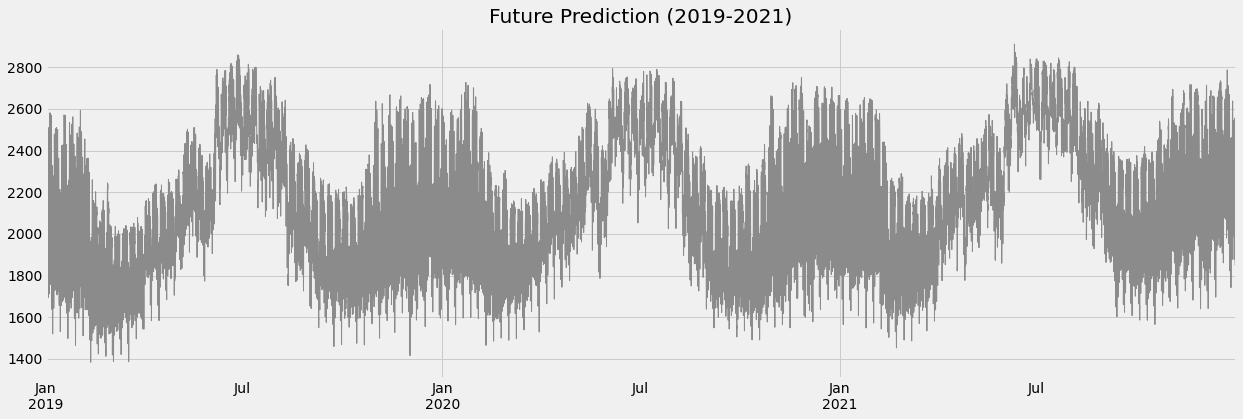

In [ ]:
future_with_features['pred'].plot(figsize=(19,6),color=color_pal[4],ms=1,lw=1,title='Future Prediction (2019-2021)')

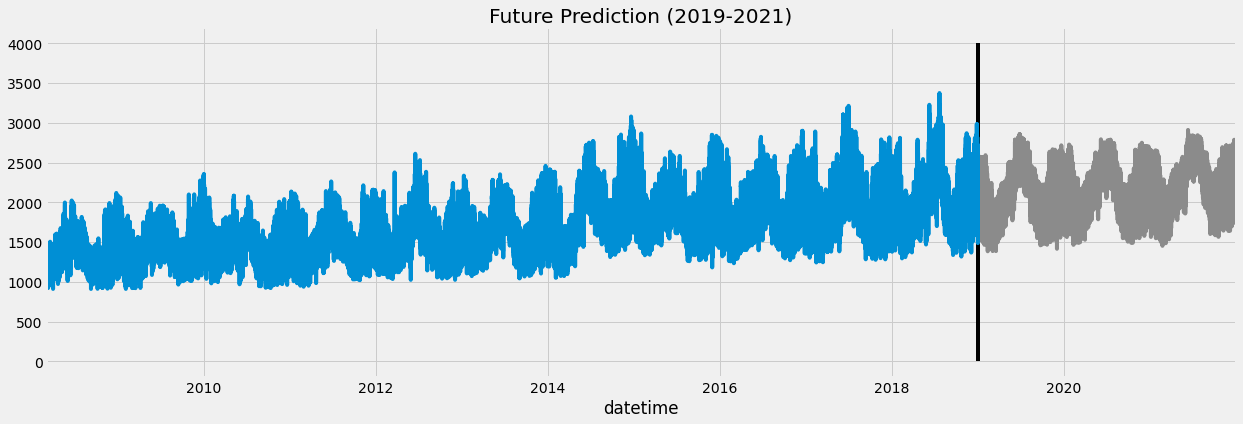

In [ ]:
future_with_features['pred'].plot(figsize=(19,6),color=color_pal[4],title='Future Prediction (2019-2021)')
df['energy'].plot()
plt.vlines(future_with_features.index.min(),ymin=0,ymax=4000)

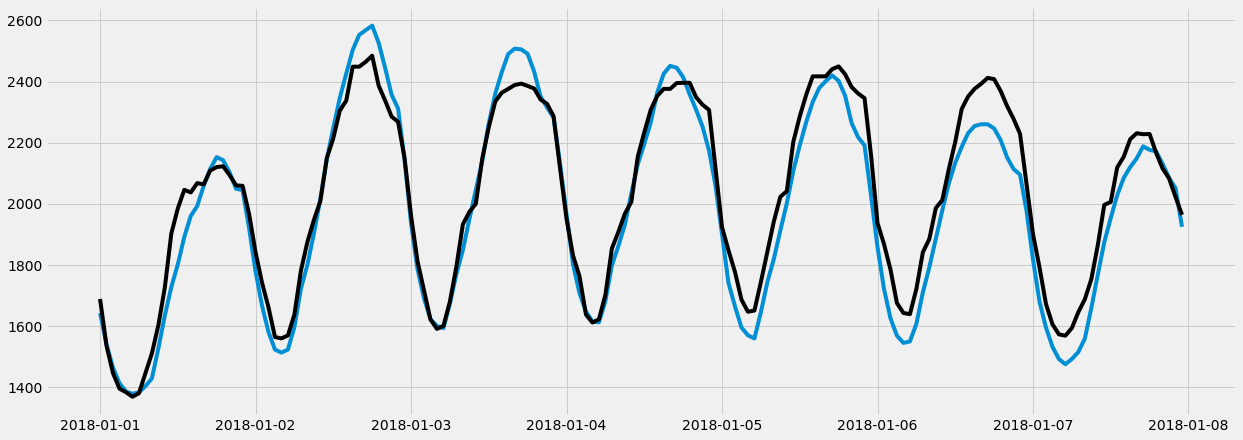

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(19,7))
ax.plot(df[(df.index >= '2018-01-01')&(df.index < '2018-01-08')].index,df[(df.index >= '2018-01-01')&(df.index < '2018-01-08')]['energy'])
ax.plot(df[(df.index >= '2018-01-01')&(df.index < '2018-01-08')].index, reg.predict(df[(df.index >= '2018-01-01')&(df.index < '2018-01-08')][features]),color='black')

In [ ]:
reg.save_model('xgb_model.json')

In [ ]:
reg_new=xgb.XGBRegressor()
reg_new.load_model('xgb_model.json')

In [ ]:
pd.read_csv('test_WudNWDM.csv')

,row_id,datetime
0,94993,2019-01-01 00:00:00
1,94994,2019-01-01 01:00:00
2,94995,2019-01-01 02:00:00
3,94996,2019-01-01 03:00:00
4,94997,2019-01-01 04:00:00
...,...,...
26299,121292,2021-12-31 19:00:00
26300,121293,2021-12-31 20:00:00
26301,121294,2021-12-31 21:00:00
26302,121295,2021-12-31 22:00:00


In [ ]:
sub=pd.read_csv('sample_submission_jn0a7vR.csv')
sub

,row_id,energy
0,94993,1702.995014
1,94994,1702.995014
2,94995,1702.995014
3,94996,1702.995014
4,94997,1702.995014
...,...,...
26299,121292,1702.995014
26300,121293,1702.995014
26301,121294,1702.995014
26302,121295,1702.995014


In [ ]:
future_with_features

,energy,hour,dayofweek,quarter,month,year,dayofyear,low_hr_consumption,lag_1year,lag_2year,lag_3year,lag_4year,lag_5year,isfuture,pred
2019-01-01 00:00:00,NaN,0,1,1,1,2019,1,0,2056.9926,2058.413200,1685.3648,1688.6632,1467.4200,True,1939.430664
2019-01-01 01:00:00,NaN,1,1,1,1,2019,1,0,1910.1082,1912.805600,1552.0316,1561.2947,1358.1775,True,1827.694824
2019-01-01 02:00:00,NaN,2,1,1,1,2019,1,0,1791.5742,1794.116000,1458.9988,1459.6113,1293.1500,True,1759.440552
2019-01-01 03:00:00,NaN,3,1,1,1,2019,1,1,1704.8122,1724.800534,1403.1584,1402.0048,1264.6600,True,1665.783447
2019-01-01 04:00:00,NaN,4,1,1,1,2019,1,1,1642.9790,1673.798800,1357.3672,1383.8244,1229.9725,True,1612.962769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,NaN,19,4,4,12,2021,365,0,2645.7508,2109.942800,2103.8751,2258.5004,2898.2548,True,2572.334229
2021-12-31 20:00:00,NaN,20,4,4,12,2021,365,0,2528.9924,2055.460400,2062.3788,2177.2374,2833.9020,True,2582.166992
2021-12-31 21:00:00,NaN,21,4,4,12,2021,365,0,2422.0548,2028.482400,2010.3498,2110.2718,2774.3068,True,2603.161865
2021-12-31 22:00:00,NaN,22,4,4,12,2021,365,0,2364.9032,2028.745600,2021.8977,2084.7320,2743.2572,True,2546.777588


In [ ]:
sub['energy']=future_with_features['pred'].to_list()

In [ ]:
sub

,row_id,energy
0,94993,1939.430664
1,94994,1827.694824
2,94995,1759.440552
3,94996,1665.783447
4,94997,1612.962769
...,...,...
26299,121292,2572.334229
26300,121293,2582.166992
26301,121294,2603.161865
26302,121295,2546.777588


In [ ]:
sub.to_csv('sub4_base_addcols_lr0.02.csv',index=False)

In [ ]:
sub

,row_id,energy
0,94993,1939.430664
1,94994,1827.694824
2,94995,1759.440552
3,94996,1665.783447
4,94997,1612.962769
...,...,...
26299,121292,2572.334229
26300,121293,2582.166992
26301,121294,2603.161865
26302,121295,2546.777588


Index(['row_id', 'energy'], dtype='object')